In [20]:
import numpy as np
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
import seaborn as sns
import time

'''Test file for second-order reactions across borders: Algorithm for explicit exact scheme, tau scheme, tau vcap approx scheme'''
# Parameters

np.random.seed(0)

# Parameters

deltat=0.005
D1=0.8
deltar=np.sqrt(deltat*2*D1)
Lx=deltar
a=2*deltar
Ly=deltar

# whole domain is a times Ly, and each domain is deltar times deltar

sigma=0.01
r1_macro=0.01 # infection rate macro
r1=r1_macro/(np.pi*(sigma**2))  # infection rate mictoe


BC1=np.array([300])
BC2=np.array([150])

nA=5
nB=2
print(BC1*(deltar**2), BC2*(deltar**2 ),'X in CD')
print(nA/(deltar**2), nB/(deltar**2), 'C in PD' )


def euclid(v1, v2):
    
    '''
    Returns the euclidean distance between arrays v1 and v2 in an
    efficient way
    v1,v2=vectors with the same length
    '''
    dist = [(a-b)**2 for a,b in zip(v1, v2)]
    dist = np.sqrt(sum(dist))
    return dist
def virtual(Lx, deltar, N,i):
    
    
    
    Virtual=[None]*N
    for j in range(N):
        
        Virtual[j]=np.array([np.random.uniform(Lx, Lx+deltar), np.random.uniform(deltar*i,deltar*(i+1))])
    return Virtual
def second_order_reaction(A, B, rate, deltat, sigma, Lx):
    
    '''Simulates the second order reaction S+I->2I, if S and I are closer then sigma 
    (reaction radius). It returns the new list of S particles with removed particles, a list of 
    I particles with new particles and a list of the new particles (new list of B=previous list of B +children)
    A, B=list of 2D arrays
    A=Preys
    B=Predators
    rate=microscopic reaction rate
    deltat=time-step size
    sigma=reaction radi
    '''
  
    p=1-np.exp(-rate*deltat)
    CH=[]
    for i in reversed(range(len(A))):
        for j in reversed(range(len(B))):
            if euclid(A[i], B[j])<= sigma and p>np.random.rand():
                
                child=B[j]
               
                CH.append(child)
                    
                B.pop(j)
                A.pop(i)
                break

    return A, CH, B


def eatcompactExplicit(A, B, Lx, deltar,BC1, BC2, rate, sigma, deltat):
    '''
    Hybrid algorithm for second order reaction S+I->2I, if S and I are closer than sigma 
    (reaction radius). It returns the new list of S particles with removed particles, a list of 
    I particles with new particles and a list of the new particles (new list of B = previous list of B + children).
    A, B = list of 2D arrays
    deltar = length of boundary domain
    BC1 = boundary concentration of A particles
    BC2 = boundary concentration of B particles
    rate = microscopic reaction rate
    sigma = reaction radius
    L = x-boundary coordinate
    deltat = time-step size
    '''
    
    kindergarten = []

    # Create all Virtual Predators and Preys
    VirtualPreys = []
    for i in range(len(BC1)): 
        integer = int(BC1[i])
        
        VirtualPreys.extend(virtual(Lx, deltar, integer, i))

    VirtualPreds = []
    for i in range(len(BC2)):
        integer = int(BC2[i])
        VirtualPreds.extend(virtual(Lx, deltar, integer, i))

    # Combine actual and virtual particles for reactions
    AllPreys = A + []
    AllPreds = B + []
    
    # reactions between particles in the particle domain
    SurvivedPreys, children, NotReactedPred = second_order_reaction(AllPreys, AllPreds, rate, deltat, sigma, Lx)
    
    kindergarten.extend(children)
    
    # reactions between preys in the c domain and preds in PB
    
    PreysinCD, childrenvirtual, NotReactedPred = second_order_reaction(VirtualPreys, NotReactedPred, rate, deltat, sigma, Lx)
    
    
    # reactions between preds in the c domain and preys in PB
    
    SurvivedPreys, children, PredsinCD = second_order_reaction(SurvivedPreys, VirtualPreds, rate, deltat, sigma, Lx)
    
    kindergarten.extend(children)
    
    
    DecPreys = np.zeros(len(BC1))
    SingleVirtualPrey = []
    for i in range(len(BC1)):
         dec = BC1[i] - int(BC1[i])
         SingleVirtualPrey.append(virtual(Lx, deltar, 1, i))
         DecPreys[i] = dec

    DecPreds = np.zeros(len(BC2))
    SingleVirtualPred = []
    for i in range(len(BC2)):
         dec = BC2[i] - int(BC2[i])
         SingleVirtualPred.append(virtual(Lx, deltar, 1, i))
         DecPreds[i] = dec

    for i in range(len(SingleVirtualPrey)):
        Ignore, children_in_cdomain, NotReactedPred = second_order_reaction(SingleVirtualPrey[i], NotReactedPred, rate * DecPreys[i], deltat, sigma, Lx)
    
    for i in range(len(SingleVirtualPred)):
        SurvivedPreys, childrenvirtual,VirtualPreds = second_order_reaction(SurvivedPreys, SingleVirtualPred[i], rate * DecPreds[i], deltat, sigma, Lx)
        kindergarten.extend(childrenvirtual)
       

    return SurvivedPreys, kindergarten, NotReactedPred




def eatcompactTau(A, B, Lx, deltar, BC1, BC2,rate, sigma, deltat,Mdiscr):

    # Perform reactions inside the particle domain
    
    AllPreys = A + []
    AllPreds = B + []

    # Perform reactions
    
    kindergarten=[]
    
    
    # Perform reactions across borders A (Sus) in PD and B (Inf) in concentration
    for i in range(len(BC2)):
        
        
        for j in reversed(range(len(AllPreys))):   
            # calculate the distance from A to the reservoir
            d=abs(AllPreys[j][0]-Lx)
            if d<=sigma:
                h=sigma-d
                Vcap = sigma**2 * np.arccos((sigma - h) / sigma) - (sigma - h) * np.sqrt(2 * sigma * h - h**2)
                
                Lambda1=Vcap*rate*BC2[i]/((deltar) * deltar)*(deltat/Mdiscr)
                p=1-np.exp(-Lambda1)
               
            else:
                p=0
            for k in range(Mdiscr):
                if p>np.random.uniform():
                    # A reacts with B in the concentration domain
                    # remove A 
                    
                    AllPreys.pop(j)
                    
                    
                    break  # Break out of the `k` loop
        
            
                
    
    # Perform reactions across borders A (Sus) in concentration and B  (Inf)in particle
    children2 = []
    
    for i in range(len(BC1)):
        
        for j in reversed(range(len(AllPreds))):
            
            # Calculate the distance from A to the reservoir
            d = abs(AllPreds[j][0] - Lx)
            
            if d <= sigma:
                h = sigma - d
                Vcap = sigma**2 * np.arccos((sigma - h) / sigma) - (sigma - h) * np.sqrt(2 * sigma * h - h**2)
                
                Lambda = Vcap * rate * BC1[i] / ((deltar)**2) * (deltat / Mdiscr)
                
                p = 1 - np.exp(-Lambda)
            else:
                p = 0
            
            for k in range(Mdiscr):
                
                if p > np.random.uniform():
                    # A reacts with B in the concentration domain
                    # Remove A
                    children2.append(AllPreds[j])
                    AllPreds.pop(j)
                    
                    
                    break  # Break out of the `k` loop
    
    
    # reactions in PB domain
    kindergarten.extend(children2)            
    # Pause the timer for internal reactions
    internal_start = time.time()
    AllPreys, childrenIntern, AllPredsAfterIntern = second_order_reaction(AllPreys, AllPreds, rate, deltat, sigma, Lx)
    kindergarten.extend(childrenIntern)
    internal_end = time.time()

    # Calculate elapsed time
    internal_time = internal_end - internal_start
   

    return AllPreys, kindergarten,AllPredsAfterIntern
def eatcompactTauVcapApprox(A, B, Lx, deltar, BC1, BC2,rate, sigma, deltat, M):
    
    # Perform reactions inside the particle domain
    
    AllPreys = A + []
    AllPreds = B + []

    # Perform reactions
    
    childreninthePBDomain=[]
    
    
    # Perform reactions across borders A (Sus) in PD and B (Inf) in concentration
    for i in range(len(BC2)):
        reaction_occurred = False  # Flag to track if a reaction occurs
        BPart=rate*BC2[i]/((deltar) * deltar)*(deltat/M)
        h=0
        k=0
        for j in reversed(range(len(AllPreys))):
            d=abs(AllPreys[j][0]-Lx)
            
            if d<=sigma:
                h=h+sigma-d
        if k>0:        
            h=h/k
        else:
            break
        h = min(h, sigma)
        Vcap = sigma**2 * np.arccos((sigma - h) / sigma) - (sigma - h) * np.sqrt(2 * sigma * h - h**2)
                
        Lambda1=Vcap*BPart
        p=1-np.exp(-Lambda1)
        for j in reversed(range(len(AllPreys))):
            if d<=sigma:
                for k in range(M):
                    if p>np.random.uniform():
                        # A reacts with B in the concentration domain
                        # remove A 
                        
                        AllPreys.pop(j)
                        
                        reaction_occurred = True  # Set the flag
                        break  # Break out of the `k` loop
          
                    
    
    # Perform reactions across borders A (Sus) in concentration and B  (Inf)in particle
    children2 = []
    
    for i in range(len(BC1)):
        
        reaction_occurred = False  # Flag to track if a reaction occurs
        BPart=rate * BC1[i] / ((deltar)**2) * (deltat / M)
       
        H=[]
        k=0
        for j in reversed(range(len(AllPreds))):
            d=abs(AllPreds[j][0]-Lx)
            
            if d<=sigma:
                h=h+(sigma-d)
                k=k+1
                
        if k >0:        
            h=h/k
        else:
            break

        h = min(h, sigma)       
        Vcap = sigma**2 * np.arccos((sigma - h) / sigma) - (sigma - h) * np.sqrt(2 * sigma * h - h**2)
             
        Lambda=Vcap*BPart
        p = 1 - np.exp(-Lambda)
        for j in reversed(range(len(AllPreds))):
            # Calculate the distance from A to the reservoir
            d = abs(AllPreds[j][0] - Lx)
            if d <= sigma:
                for k in range(M):
                    
                    if p > np.random.uniform():
                        # A reacts with B in the concentration domain
                        # Remove A
                        children2.append(AllPreds[j])
                        AllPreds.pop(j)
                        
                        reaction_occurred = True  # Set the flag
                        break  # Break out of the `k` loop
        
           
    # reactions in PB domain
    childreninthePBDomain.extend(children2)            
    SurvivedPreys, childrenIntern, NotReactedPred = second_order_reaction(AllPreys, AllPreds, rate, deltat, sigma, Lx)
    childreninthePBDomain.extend(childrenIntern)
   

   
    return SurvivedPreys, childreninthePBDomain,NotReactedPred

[2.4] [1.2] X in CD
625.0 250.0 C in PD


In [9]:
A = list(np.column_stack((np.random.uniform(0, Lx, nA), np.random.uniform(0, Ly, nA))))
B= list(np.column_stack((np.random.uniform(0, Lx, nB), np.random.uniform(0, Ly, nB))))

In [3]:
PreyExplicit=[]
childrenExplicit=[]
PredsExplicit=[]
sim=50
start_time=time.time()
for s in range(sim):
    
    SurvivedPreys, children,NotReactedPred=eatcompactExplicit(A, B, Lx, deltar,BC1, BC2, r1, sigma, deltat)
    PreyExplicit.append(len(SurvivedPreys))
    childrenExplicit.append(len(children))
    PredsExplicit.append(len(NotReactedPred))
end_time=time.time()

TimeExplicit=end_time-start_time

In [4]:
PreyTau=[]
childrenTau=[]
PredsTau=[]
sim=50
M=1
start_time=time.time()
for s in range(sim):
    SurvivedPreys, children,NotReactedPred=eatcompactTau(A, B, Lx, deltar,BC1, BC2, r1, sigma, deltat,1)
    PreyTau.append(len(SurvivedPreys))
    childrenTau.append(len(children))
    PredsTau.append(len(NotReactedPred))
end_time=time.time()

TimeTau=end_time-start_time

In [5]:
PreyTauApprox=[]
childrenTauApprox=[]
PredsTauApprox=[]
sim=50
M=1
start_time=time.time()
for s in range(sim):
    SurvivedPreys, children,NotReactedPred=eatcompactTauVcapApprox(A, B, Lx, deltar,BC1, BC2, r1, sigma, deltat,M)
    PreyTauApprox.append(len(SurvivedPreys))
    childrenTauApprox.append(len(children))
    PredsTauApprox.append(len(NotReactedPred))

end_time=time.time()

TimeTauApprox=end_time-start_time

In [6]:

# Assuming PreyExplicit, childrenExplicit, PredsExplicit, PreyTau, childrenTau, PredsTau are lists of scalar values

# Calculate the mean and variance for each list
mean_prey = np.mean(PreyExplicit)
var_prey = np.var(PreyExplicit)

mean_children = np.mean(childrenExplicit)
var_children = np.var(childrenExplicit)

mean_preds = np.mean(PredsExplicit)
var_preds = np.var(PredsExplicit)

mean_preyTau = np.mean(PreyTau)
var_preyTau = np.var(PreyTau)

mean_childrenTau = np.mean(childrenTau)
var_childrenTau = np.var(childrenTau)

mean_predsTau = np.mean(PredsTau)
var_predsTau = np.var(PredsTau)


mean_preyTauApprox = np.mean(PreyTauApprox)
var_preyTauApprox = np.var(PreyTauApprox)

mean_childrenTauApprox = np.mean(childrenTauApprox)
var_childrenTauApprox= np.var(childrenTauApprox)

mean_predsTauApprox = np.mean(PredsTauApprox)
var_predsTauApprox = np.var(PredsTauApprox)

print(mean_prey, mean_preyTau, mean_preyTauApprox, 'prey')
print(mean_children, mean_childrenTau,  mean_childrenTauApprox,'children')
print(mean_preds, mean_predsTau, mean_predsTauApprox,  'not reacted preds')
print(TimeExplicit, TimeTau, TimeTauApprox,  'times')


4.76 4.78 4.68 prey
0.24 0.22 0.32 children
1.76 1.78 1.68 not reacted preds
0.30933690071105957 0.00848698616027832 0.005865335464477539 times


In [29]:
nA = np.arange(1, 51, 5)
nB = np.arange(1, 21, 2)

TimeApprox=np.zeros(len(nA))
for i in range(len(nA)):
    # generate uniformly distributed particles in [0,0.5][0,1]
    A = list(np.column_stack((np.random.uniform(0, Lx, nA[i]), np.random.uniform(0, Ly, nA[i]))))
    B= list(np.column_stack((np.random.uniform(0, Lx, nB[i]), np.random.uniform(0, Ly, nB[i]))))
    PreyTauApprox=[]
    childrenTauApprox=[]
    PredsTauApprox=[]
    sim=200
    M=1
    start_time=time.time()
    for s in range(sim):
        SurvivedPreys, children,NotReactedPred=eatcompactTauVcapApprox(A, B, Lx, deltar,BC1, BC2, r1, sigma, deltat,M)
        PreyTauApprox.append(len(SurvivedPreys))
        childrenTauApprox.append(len(children))
        PredsTauApprox.append(len(NotReactedPred))
    
    end_time=time.time()
    
    TimeApprox[i]=end_time-start_time
    


In [30]:
nA = np.arange(1, 51, 5)
nB = np.arange(1, 21, 2)
TimeTau=np.zeros(len(nA))
for i in range(len(nA)):
    # generate uniformly distributed particles in [0,0.5][0,1]
    A = list(np.column_stack((np.random.uniform(0, Lx, nA[i]), np.random.uniform(0, Ly, nA[i]))))
    B= list(np.column_stack((np.random.uniform(0, Lx, nB[i]), np.random.uniform(0, Ly, nB[i]))))
    PreyTauApprox=[]
    childrenTauApprox=[]
    PredsTauApprox=[]
    sim=200
    M=1
    start_time=time.time()
    for s in range(sim):
        SurvivedPreys, children,NotReactedPred=eatcompactTau(A, B, Lx, deltar,BC1, BC2, r1, sigma, deltat,M)
        PreyTauApprox.append(len(SurvivedPreys))
        childrenTauApprox.append(len(children))
        PredsTauApprox.append(len(NotReactedPred))
    
    end_time=time.time()
    
    TimeTau[i]=end_time-start_time

In [31]:
nA = np.arange(1, 51, 5)
nB= np.arange(1, 21, 2)
TimeExact=np.zeros(len(nA))
for i in range(len(nA)):
    # generate uniformly distributed particles in [0,0.5][0,1]
    A = list(np.column_stack((np.random.uniform(0, Lx, nA[i]), np.random.uniform(0, Ly, nA[i]))))
    B= list(np.column_stack((np.random.uniform(0, Lx, nB[i]), np.random.uniform(0, Ly, nB[i]))))
    PreyTauApprox=[]
    childrenTauApprox=[]
    PredsTauApprox=[]
    sim=50
    M=1
    start_time=time.time()
    for s in range(sim):
        SurvivedPreys, children,NotReactedPred=eatcompactExplicit(A, B, Lx, deltar,BC1, BC2, r1, sigma, deltat)
        PreyTauApprox.append(len(SurvivedPreys))
        childrenTauApprox.append(len(children))
        PredsTauApprox.append(len(NotReactedPred))
    
    end_time=time.time()
   
    
    TimeExact[i]=end_time-start_time

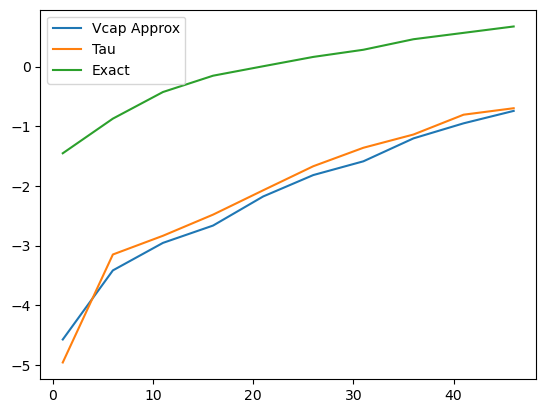

In [32]:
fig=plt.figure()
plt.plot(nA,np.log(TimeApprox), label='Vcap Approx')
plt.plot(nA,np.log(TimeTau), label='Tau')
plt.plot(nA,np.log(TimeExact), label='Exact')
plt.legend()

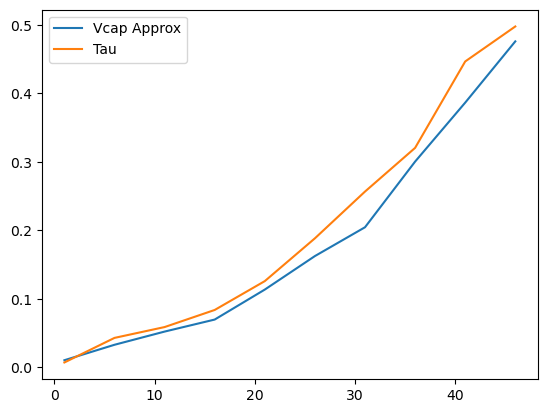

In [33]:
fig=plt.figure()
plt.plot(nA,TimeApprox, label='Vcap Approx')
plt.plot(nA,TimeTau, label='Tau')

plt.legend()

0
1
2
3
4
5
6


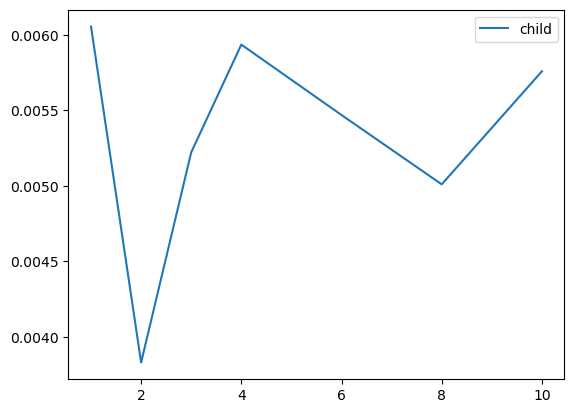

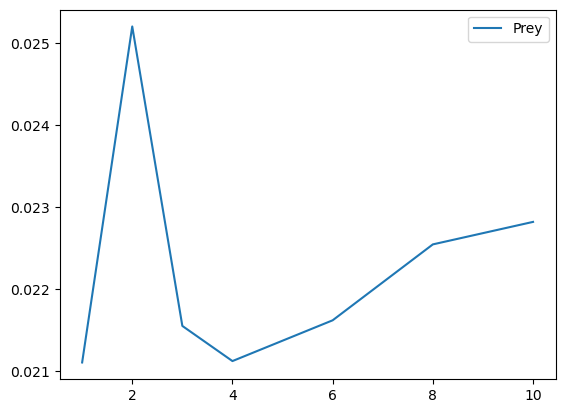

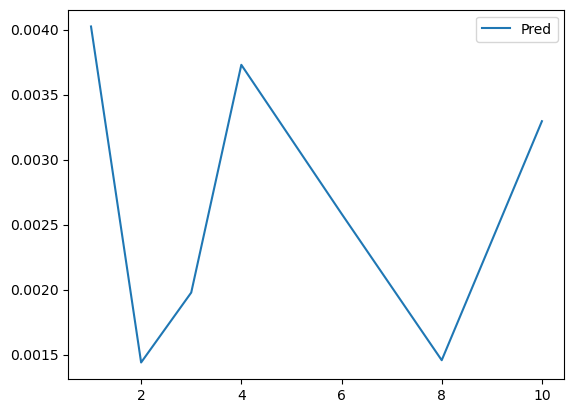

In [22]:
nA=400
nB=400
cA=5000
cB=5000
A = list(np.column_stack((np.random.uniform(0, Lx, nA), np.random.uniform(0, Ly, nA))))
B= list(np.column_stack((np.random.uniform(0, Lx, nB), np.random.uniform(0, Ly, nB))))
# reference solution

PreyExplicit=[]
childrenExplicit=[]
PredsExplicit=[]
sim=500

for s in range(sim):
    
    SurvivedPreys, children,NotReactedPred=eatcompactExplicit(A, B, Lx, deltar,BC1, BC2, r1, sigma, deltat)
    PreyExplicit.append(len(SurvivedPreys))
    childrenExplicit.append(len(children))
    PredsExplicit.append(len(NotReactedPred))

mean_prey = np.mean(PreyExplicit)
var_prey = np.var(PreyExplicit)

mean_children = np.mean(childrenExplicit)
var_children = np.var(childrenExplicit)

mean_preds = np.mean(PredsExplicit)
var_preds = np.var(PredsExplicit)


sim=500
ListM=[1,2,3,4,6,8,10]
ErrorC=np.zeros(len(ListM))
ErrorPrey=np.zeros(len(ListM))
ErrorPred=np.zeros(len(ListM))
for i in range(len(ListM)):
    PreyTau=[]
    childrenTau=[]
    PredsTau=[]
    print(i)
    for s in range(sim):
        SurvivedPreys, childreninthePBDomain,NotReactedPred=eatcompactTau(A, B, Lx, deltar,BC1, BC2, r1, sigma, deltat,ListM[i])
        PreyTau.append(len(SurvivedPreys))
        childrenTau.append(len(childreninthePBDomain))
        PredsTau.append(len(NotReactedPred))

    # Calculate the mean and variance for each list
    
    
    mean_preyTau = np.mean(PreyTau)
    var_preyTau = np.var(PreyTau)
    
    mean_childrenTau = np.mean(childrenTau)
    var_childrenTau = np.var(childrenTau)
    
    mean_predsTau = np.mean(PredsTau)
    var_predsTau = np.var(PredsTau)
    
    ErrorC[i]= np.abs(mean_childrenTau-mean_children)/mean_children
    ErrorPrey[i]= np.abs(mean_preyTau-mean_prey)/mean_prey
    ErrorPred[i]= np.abs(mean_predsTau-mean_preds)/mean_preds


fig=plt.figure()

plt.plot(ListM, ErrorC, label='child')
plt.legend()
fig=plt.figure()
plt.plot(ListM, ErrorPrey, label='Prey')
plt.legend()
fig=plt.figure()
plt.plot(ListM, ErrorPred, label='Pred')
plt.legend()


In [23]:
print(deltat)

0.005
